In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime

from torch.utils.tensorboard import SummaryWriter

In [2]:
#model.py
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # Conv2d layers expect input with the shape (n_samples, channels, height, width) 
            # e.g., (1000, 1, 224, 224), source https://pytorch.org/docs/stable/nn.html#conv2d
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 256, 256))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    assert preds.shape == x.shape

if __name__ == "__main__":
    test()

In [3]:
import torch.nn.functional as F

class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        iflat = y_pred.view(-1)
        tflat = y_true.view(-1)
        intersection = (iflat * tflat).sum()
        dsc = ((2. * intersection + self.smooth) /
                  (iflat.sum() + tflat.sum() + self.smooth))
        return 1. - dsc
    
class DiceBCELoss(nn.Module):
    def __init__(self, weight=1):
        super(DiceBCELoss, self).__init__()
        self.weight = weight
#         self.BCE = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets, smooth=1):
        
#         bce_loss = self.BCE(torch.sigmoid(inputs), targets)
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        dice_BCE = self.weight * dice_loss + (1 - self.weight) * bce_loss
        return dice_BCE

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        return dice_loss

def dice_coef(output, target):
    smooth = 1e-5
    # we need to use sigmoid because the output of Unet is logit.
    output = torch.sigmoid(output).view(-1).data.cpu().numpy()
    target = target.view(-1).data.cpu().numpy()
    intersection = (output * target).sum()
    

    return (2. * intersection + smooth) / \
        (output.sum() + target.sum() + smooth)

def val_dice_coef(output, target):
    "This metric is for validation purpose"
    smooth = 1e-5

    output = output.view(-1)
    output = (output>0.5).float().cpu().numpy()
    target = target.view(-1).data.cpu().numpy()
    intersection = (output * target).sum()
    

    return (2. * intersection + smooth) / \
        (output.sum() + target.sum() + smooth)

def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)

In [4]:
# #dataset.py
# import os
# from PIL import Image
# from torch.utils.data import Dataset
# import numpy as np

# class CarvanaDataset(Dataset):
#     def __init__(self, image_dir, mask_dir, transform=None):
#         self.image_dir = image_dir
#         self.mask_dir = mask_dir
#         self.transform = transform
#         #self.images = os.listdir(image_dir)
#         images_path = os.path.join(self.image_dir, NPY_DATA_FILE)
#         images_array = np.array(np.load(images_path))
#         number_of_exams = len(images_array)
#         images_list = np.array_split(images_array, number_of_exams)
#         images_list = [np.squeeze(exam, axis=0) for exam in images_list]
#         self.images = np.concatenate(images_list, axis=2)
        
#         masks_path = os.path.join(self.mask_dir, NPY_DATA_FILE)
#         masks_array = np.array(np.load(masks_path))
#         masks_list = np.array_split(masks_array, number_of_exams)
#         masks_list = [np.squeeze(exam, axis=0) for exam in masks_list]
#         self.masks = np.concatenate(masks_list, axis=2)

#     def __len__(self):
# #         return len(self.images)
#         return self.images.shape[-1]

#     def __getitem__(self, index):
#         image = np.array(self.images[:,:,index]).astype('float')
#         mask = np.array(self.masks[:,:,index]).astype('float')
#         if self.transform is None:
#             if index == 0:
#                 print(f"Image shape with no transform pre expan: {image.shape}")
#                 print(f"Mask shape with no transform pre expan: {mask.shape}")
#             image = np.expand_dims(image, 0)
#             mask = np.expand_dims(mask, 0)
#             if index == 0:
#                 print(f"Image shape with no transform post expan: {image.shape}")
#                 print(f"Mask shape with no transform post expan: {mask.shape}")
#                 print('\n')
#         if self.transform is not None:
#             augmentations = self.transform(image=image, mask=mask)
#             image = augmentations["image"]
#             mask = augmentations["mask"]
#         return image, mask

In [5]:
#dataset.py
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class LungNoduleDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
         return len(self.images)


    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = np.array(np.load(img_path)).astype('float')
        mask = np.array(np.load(mask_path)).astype('float')
        if self.transform is None:
            if index == 0:
                print(f"Image shape with no transform pre expan: {image.shape}")
                print(f"Mask shape with no transform pre expan: {mask.shape}")
            image = np.expand_dims(image, 0)
            mask = np.expand_dims(mask, 0)
            if index == 0:
                print(f"Image shape with no transform post expan: {image.shape}")
                print(f"Mask shape with no transform post expan: {mask.shape}")
                print('\n')
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        return image, mask

In [6]:
#utils.py
import torch
import torchvision
import cv2
# from dataset import LungNoduleDataset
from torch.utils.data import DataLoader

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = LungNoduleDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )
    val_ds = LungNoduleDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )
    return train_loader, val_loader

def validate(loader, model, loss_fn, epoch=None, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    dsc = 0
    accumulated_loss = 0
    iou = 0
    val_dice = 0
    batch_size = len(loader)
    model.eval()
    
    with torch.no_grad():
        for idx, (x, y) in enumerate(loader):
            if (idx == 5) and (epoch % 5 == 0):
                fig, ax = plt.subplots(3,4, figsize=(16,10))
                if batch_size > 4:
                    x_plot = x[:4]
                    y_plot = y[:4]
                else:
                    x_plot = x
                    y_plot = y
                for j, data in enumerate(x_plot):
                    data = np.squeeze(data)
                    ax[0,j].imshow(data.numpy())
                for k, data in enumerate(y_plot):
                    mask_data = np.squeeze(data)
                    ax[1,k].imshow(mask_data.numpy())
            
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = model(x)
            
            dsc += dice_coef(preds, y).item()
            accumulated_loss += loss_fn(preds, y).item()
            iou += iou_score(preds, y)
#             val_dice += val_dice_coef(preds, y)
            
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)

            if (idx == 5) and (epoch % 5 == 0):
                if batch_size > 4:
                    preds_plot = preds[:4]
                else:
                    preds_plot = x
                for l, data in enumerate(preds_plot):
                    pred_data = data.cpu()
                    pred_data = np.squeeze(pred_data).numpy()
                    ax[2,l].imshow(pred_data)
                plt.show()
                plt.close('all')
    if epoch != None:
        print(f"Epoch: {int(epoch) + 1}/{NUM_EPOCHS}")
    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dsc/batch_size}")
#     print(f"Val Dice score: {val_dice/batch_size}")
    model.train()
    return {'loss': accumulated_loss/batch_size,
            'dice': dsc/batch_size,
            'iou': iou/batch_size}

def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.png")
#         torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}/gt_{idx}.png")

    model.train()

Finished data loading.


  0%|          | 0/707 [00:00<?, ?it/s]/home/mainlab1/PauloLucas/lib/python3.6/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
100%|██████████| 707/707 [03:42<00:00,  3.18it/s, loss=0.581]


=> Saving checkpoint


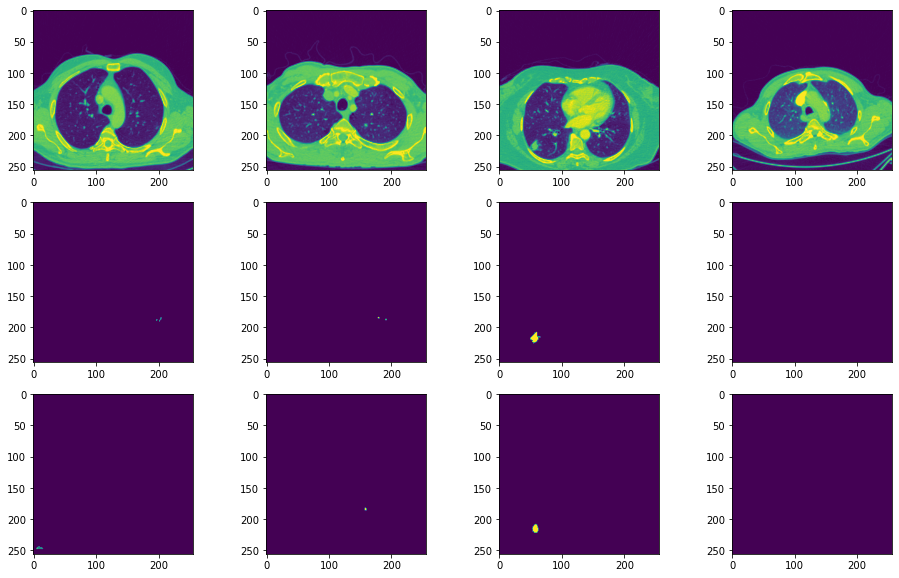

Epoch: 1/30
Got 69204983/69402624 with acc 99.72
Dice score: 0.011513505466698645


100%|██████████| 707/707 [03:35<00:00,  3.29it/s, loss=0.522]


=> Saving checkpoint
Epoch: 2/30
Got 69152543/69402624 with acc 99.64
Dice score: 0.10880390819117079


100%|██████████| 707/707 [03:34<00:00,  3.29it/s, loss=0.5]  


=> Saving checkpoint
Epoch: 3/30
Got 69299927/69402624 with acc 99.85
Dice score: 0.39142400864729193


100%|██████████| 707/707 [03:34<00:00,  3.30it/s, loss=0.488] 


=> Saving checkpoint
Epoch: 4/30
Got 69321977/69402624 with acc 99.88
Dice score: 0.7099587223952484


100%|██████████| 707/707 [03:34<00:00,  3.30it/s, loss=0.0698]


=> Saving checkpoint
Epoch: 5/30
Got 69313976/69402624 with acc 99.87
Dice score: 0.7029716315046579


100%|██████████| 707/707 [03:35<00:00,  3.29it/s, loss=0.0781]


=> Saving checkpoint


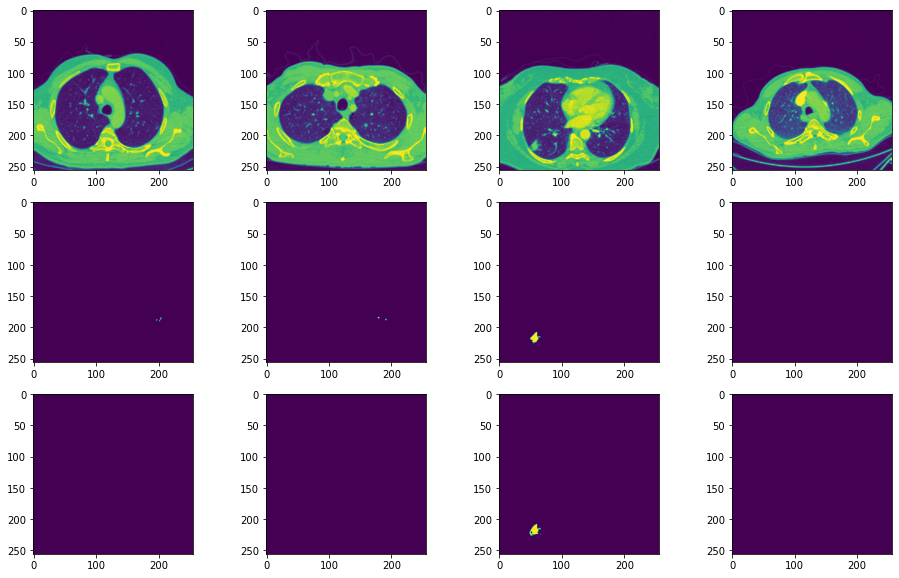

Epoch: 6/30
Got 69339107/69402624 with acc 99.91
Dice score: 0.7808818578983042


100%|██████████| 707/707 [03:37<00:00,  3.25it/s, loss=0.477] 


=> Saving checkpoint
Epoch: 7/30
Got 69340984/69402624 with acc 99.91
Dice score: 0.803175108136861


100%|██████████| 707/707 [03:37<00:00,  3.26it/s, loss=0.31]  


=> Saving checkpoint
Epoch: 8/30
Got 69336529/69402624 with acc 99.90
Dice score: 0.8052538828483714


100%|██████████| 707/707 [03:36<00:00,  3.26it/s, loss=0.046] 


=> Saving checkpoint
Epoch: 9/30
Got 69337952/69402624 with acc 99.91
Dice score: 0.7888645322170784


100%|██████████| 707/707 [03:39<00:00,  3.22it/s, loss=0.0245]


=> Saving checkpoint
Epoch: 10/30
Got 69334198/69402624 with acc 99.90
Dice score: 0.8015542578249862


100%|██████████| 707/707 [03:39<00:00,  3.23it/s, loss=0.0557]


=> Saving checkpoint


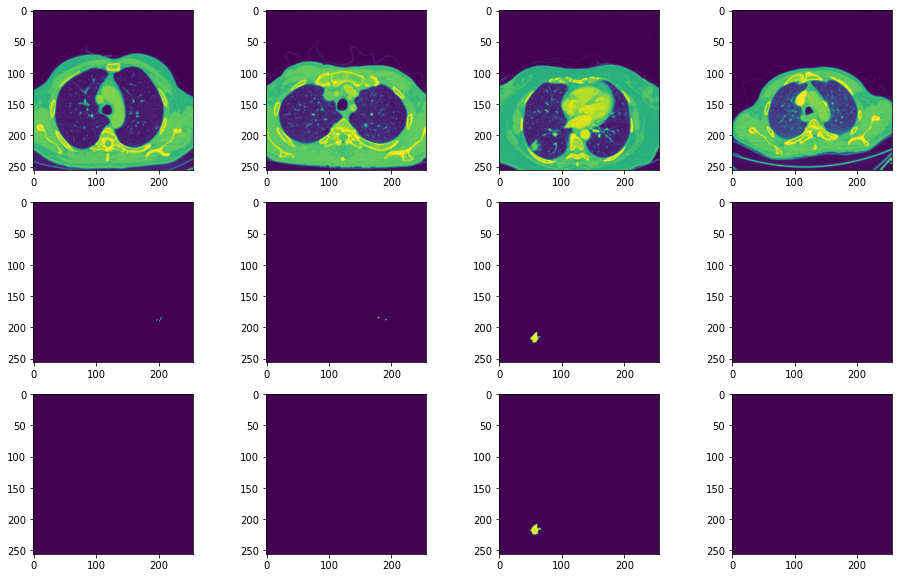

Epoch: 11/30
Got 69349798/69402624 with acc 99.92
Dice score: 0.8401775005795676


100%|██████████| 707/707 [03:39<00:00,  3.22it/s, loss=0.0288]


=> Saving checkpoint
Epoch: 12/30
Got 69349851/69402624 with acc 99.92
Dice score: 0.828694086616921


100%|██████████| 707/707 [03:40<00:00,  3.21it/s, loss=0.0201]


=> Saving checkpoint
Epoch: 13/30
Got 69351119/69402624 with acc 99.93
Dice score: 0.8366225841259058


100%|██████████| 707/707 [03:41<00:00,  3.20it/s, loss=0.512] 


=> Saving checkpoint
Epoch: 14/30
Got 69336209/69402624 with acc 99.90
Dice score: 0.8130255937205088


100%|██████████| 707/707 [03:41<00:00,  3.19it/s, loss=0.0674]


=> Saving checkpoint
Epoch: 15/30
Got 69353642/69402624 with acc 99.93
Dice score: 0.851310506036399


100%|██████████| 707/707 [03:43<00:00,  3.17it/s, loss=0.0911]


=> Saving checkpoint


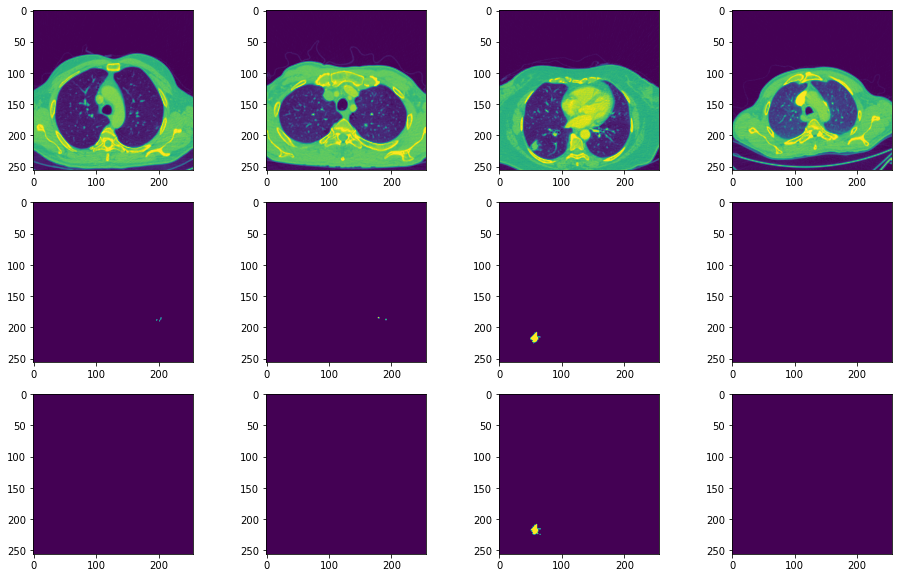

Epoch: 16/30
Got 69348327/69402624 with acc 99.92
Dice score: 0.8276640164618293


100%|██████████| 707/707 [03:43<00:00,  3.17it/s, loss=0.0485]


=> Saving checkpoint
Epoch: 17/30
Got 69351271/69402624 with acc 99.93
Dice score: 0.8389020987670402


100%|██████████| 707/707 [03:44<00:00,  3.15it/s, loss=0.0131]


=> Saving checkpoint
Epoch: 18/30
Got 69356901/69402624 with acc 99.93
Dice score: 0.85372542606908


100%|██████████| 707/707 [03:44<00:00,  3.15it/s, loss=0.0454]


=> Saving checkpoint
Epoch: 19/30
Got 69356776/69402624 with acc 99.93
Dice score: 0.8607074851166702


100%|██████████| 707/707 [03:44<00:00,  3.15it/s, loss=0.575] 


=> Saving checkpoint
Epoch: 20/30
Got 69358451/69402624 with acc 99.94
Dice score: 0.8651847992235127


100%|██████████| 707/707 [03:45<00:00,  3.13it/s, loss=0.355] 


=> Saving checkpoint


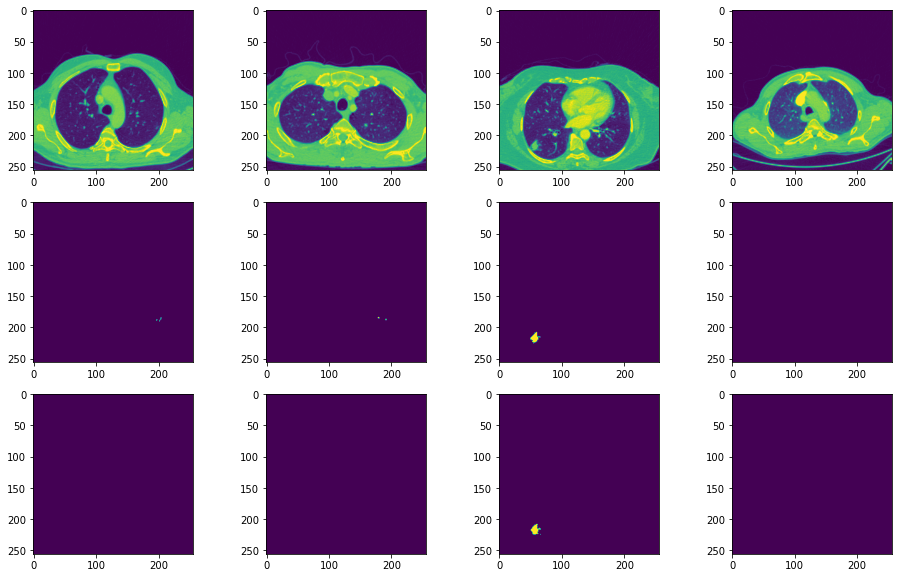

Epoch: 21/30
Got 69359094/69402624 with acc 99.94
Dice score: 0.8658879250550852


100%|██████████| 707/707 [03:42<00:00,  3.17it/s, loss=0.0453]


=> Saving checkpoint
Epoch: 22/30
Got 69357143/69402624 with acc 99.93
Dice score: 0.861157800215045


100%|██████████| 707/707 [03:42<00:00,  3.17it/s, loss=0.0678]


=> Saving checkpoint
Epoch: 23/30
Got 69346061/69402624 with acc 99.92
Dice score: 0.8289827254768329


100%|██████████| 707/707 [03:42<00:00,  3.18it/s, loss=0.0258]


=> Saving checkpoint
Epoch: 24/30
Got 69361720/69402624 with acc 99.94
Dice score: 0.8786769832267723


100%|██████████| 707/707 [03:43<00:00,  3.16it/s, loss=0.15]  


=> Saving checkpoint
Epoch: 25/30
Got 69361710/69402624 with acc 99.94
Dice score: 0.8766591464802878


100%|██████████| 707/707 [03:42<00:00,  3.17it/s, loss=0.318] 


=> Saving checkpoint


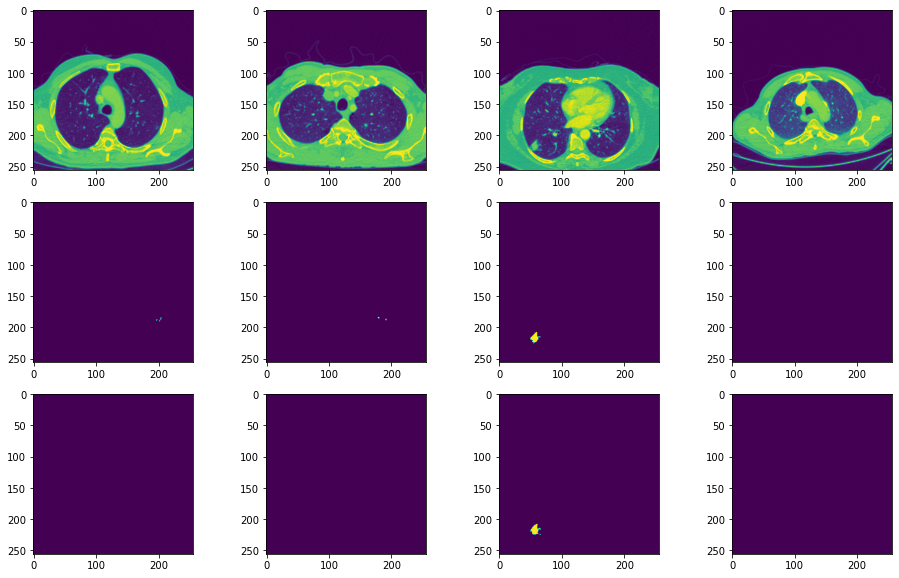

Epoch: 26/30
Got 69360152/69402624 with acc 99.94
Dice score: 0.8731775588466415


100%|██████████| 707/707 [03:43<00:00,  3.17it/s, loss=0.376] 


=> Saving checkpoint
Epoch: 27/30
Got 69361040/69402624 with acc 99.94
Dice score: 0.8774038199444424


100%|██████████| 707/707 [03:44<00:00,  3.15it/s, loss=0.472] 


=> Saving checkpoint
Epoch: 28/30
Got 69362308/69402624 with acc 99.94
Dice score: 0.8809091930086727


100%|██████████| 707/707 [03:44<00:00,  3.15it/s, loss=0.0502]


=> Saving checkpoint
Epoch: 29/30
Got 69361143/69402624 with acc 99.94
Dice score: 0.8789862912093933


100%|██████████| 707/707 [03:43<00:00,  3.17it/s, loss=0.497] 


=> Saving checkpoint
Epoch: 30/30
Got 69364835/69402624 with acc 99.95
Dice score: 0.8849972089705692
Finshed Training.
Training duration: 2:02:19.867636
Log saved as: log_bs_12_lr_0.0001_w_0.5.csv
Hyperparameters -> bs: 12 lr: 0.0001 loss: dice_bce weight: 0.5
Finished data loading.


100%|██████████| 707/707 [03:33<00:00,  3.31it/s, loss=0.552]


=> Saving checkpoint


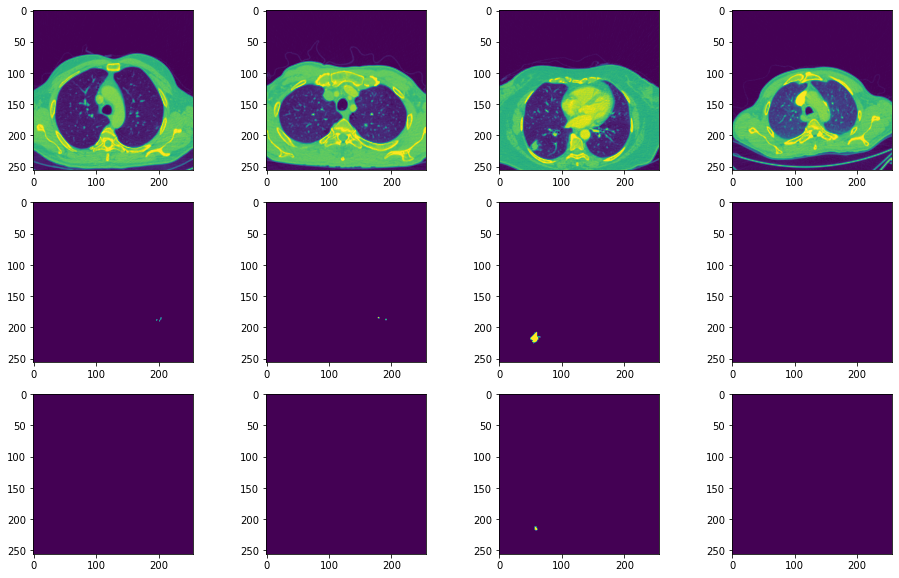

Epoch: 1/30
Got 69243737/69402624 with acc 99.77
Dice score: 0.020790452587535486


100%|██████████| 707/707 [03:33<00:00,  3.31it/s, loss=0.304]


=> Saving checkpoint
Epoch: 2/30
Got 69262503/69402624 with acc 99.80
Dice score: 0.2018023456969625


100%|██████████| 707/707 [03:35<00:00,  3.29it/s, loss=0.504] 


=> Saving checkpoint
Epoch: 3/30
Got 69287192/69402624 with acc 99.83
Dice score: 0.6267439107909875


100%|██████████| 707/707 [03:35<00:00,  3.29it/s, loss=0.0504]


=> Saving checkpoint
Epoch: 4/30
Got 69335871/69402624 with acc 99.90
Dice score: 0.7568198997077257


100%|██████████| 707/707 [03:33<00:00,  3.31it/s, loss=0.486] 


=> Saving checkpoint
Epoch: 5/30
Got 69340605/69402624 with acc 99.91
Dice score: 0.7977964871557653


100%|██████████| 707/707 [03:36<00:00,  3.27it/s, loss=0.485] 


=> Saving checkpoint


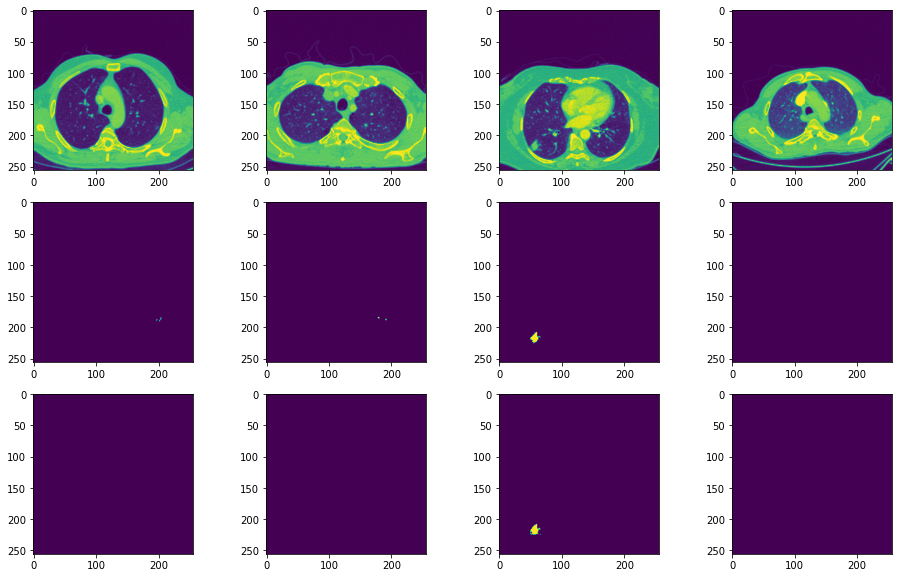

Epoch: 6/30
Got 69340087/69402624 with acc 99.91
Dice score: 0.7981610122192211


100%|██████████| 707/707 [03:37<00:00,  3.25it/s, loss=0.327] 


=> Saving checkpoint
Epoch: 7/30
Got 69349712/69402624 with acc 99.92
Dice score: 0.8374775345656044


100%|██████████| 707/707 [03:38<00:00,  3.23it/s, loss=0.0713]


=> Saving checkpoint
Epoch: 8/30
Got 69350966/69402624 with acc 99.93
Dice score: 0.8392654882536174


100%|██████████| 707/707 [03:38<00:00,  3.24it/s, loss=0.0663]


=> Saving checkpoint
Epoch: 9/30
Got 69353968/69402624 with acc 99.93
Dice score: 0.8536661538410981


100%|██████████| 707/707 [03:39<00:00,  3.22it/s, loss=0.348] 


=> Saving checkpoint
Epoch: 10/30
Got 69354834/69402624 with acc 99.93
Dice score: 0.8550261353182695


100%|██████████| 707/707 [03:39<00:00,  3.22it/s, loss=0.237] 


=> Saving checkpoint


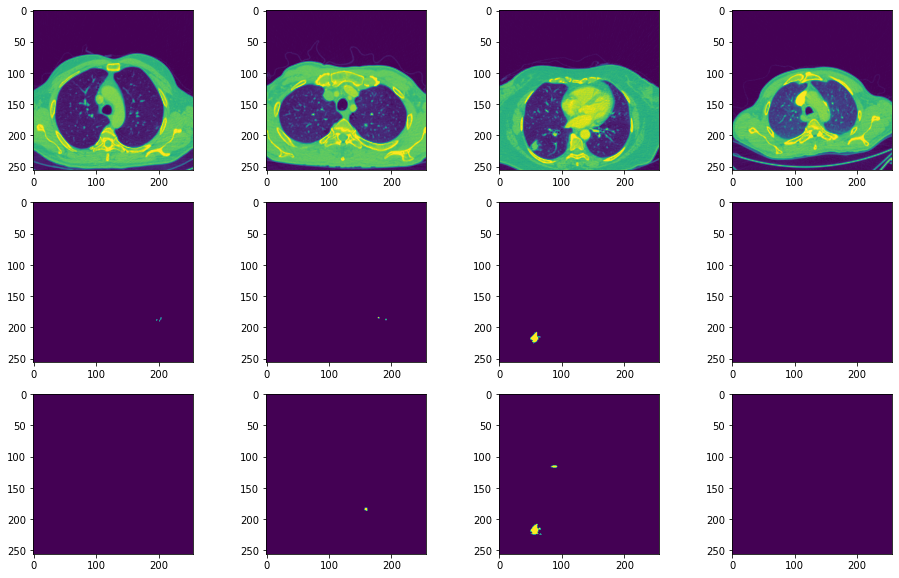

Epoch: 11/30
Got 69342036/69402624 with acc 99.91
Dice score: 0.8186950022878058


100%|██████████| 707/707 [03:41<00:00,  3.20it/s, loss=0.518] 


=> Saving checkpoint
Epoch: 12/30
Got 69353024/69402624 with acc 99.93
Dice score: 0.8526856117099009


100%|██████████| 707/707 [03:39<00:00,  3.21it/s, loss=0.449] 


=> Saving checkpoint
Epoch: 13/30
Got 69358543/69402624 with acc 99.94
Dice score: 0.8652947633692553


100%|██████████| 707/707 [03:40<00:00,  3.20it/s, loss=0.0729]


=> Saving checkpoint
Epoch: 14/30
Got 69352039/69402624 with acc 99.93
Dice score: 0.8462191165732507


100%|██████████| 707/707 [03:41<00:00,  3.19it/s, loss=0.0776]


=> Saving checkpoint
Epoch: 15/30
Got 69358669/69402624 with acc 99.94
Dice score: 0.8645486299274031


100%|██████████| 707/707 [03:42<00:00,  3.18it/s, loss=0.0465]


=> Saving checkpoint


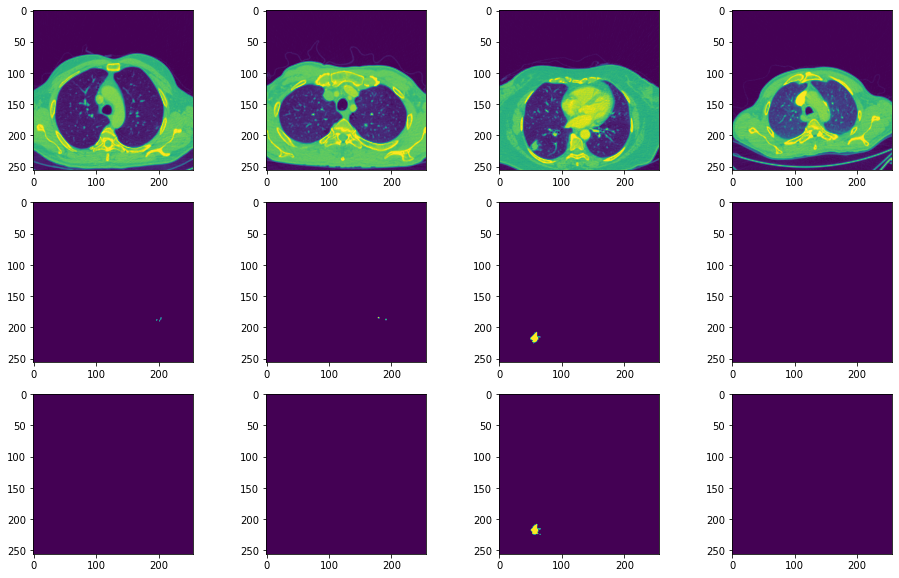

Epoch: 16/30
Got 69359186/69402624 with acc 99.94
Dice score: 0.8646597888360209


100%|██████████| 707/707 [03:42<00:00,  3.17it/s, loss=0.0294]


=> Saving checkpoint
Epoch: 17/30
Got 69362078/69402624 with acc 99.94
Dice score: 0.8785757677838116


100%|██████████| 707/707 [03:43<00:00,  3.17it/s, loss=0.0258]


=> Saving checkpoint
Epoch: 18/30
Got 69354673/69402624 with acc 99.93
Dice score: 0.8599938411657283


100%|██████████| 707/707 [03:42<00:00,  3.18it/s, loss=0.0373]


=> Saving checkpoint
Epoch: 19/30
Got 69363249/69402624 with acc 99.94
Dice score: 0.8837360365018485


100%|██████████| 707/707 [03:43<00:00,  3.16it/s, loss=0.465] 


=> Saving checkpoint
Epoch: 20/30
Got 69361759/69402624 with acc 99.94
Dice score: 0.8796747067325147


100%|██████████| 707/707 [03:43<00:00,  3.17it/s, loss=0.47]  


=> Saving checkpoint


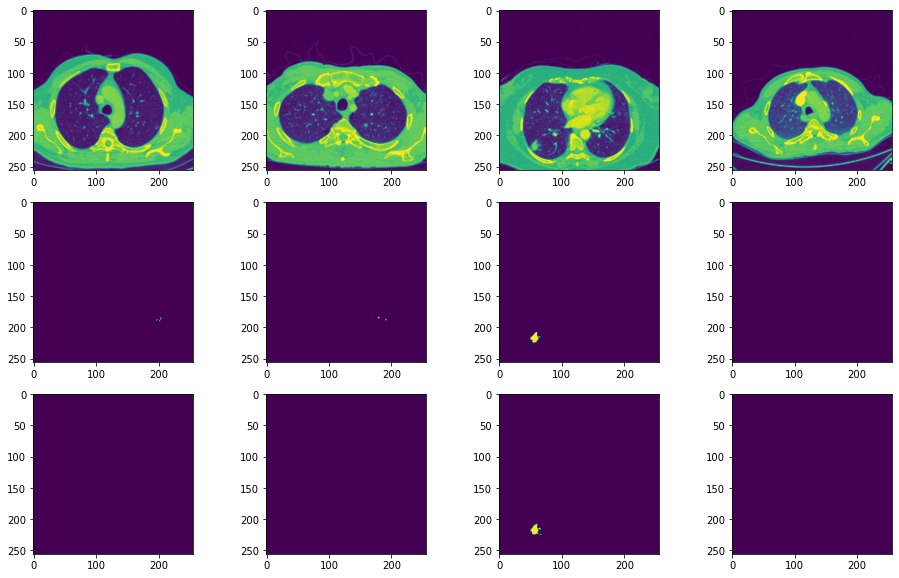

Epoch: 21/30
Got 69364795/69402624 with acc 99.95
Dice score: 0.8885330233697886


100%|██████████| 707/707 [03:44<00:00,  3.15it/s, loss=0.117] 


=> Saving checkpoint
Epoch: 22/30
Got 69365362/69402624 with acc 99.95
Dice score: 0.8888881655699933


100%|██████████| 707/707 [03:44<00:00,  3.15it/s, loss=0.0412]


=> Saving checkpoint
Epoch: 23/30
Got 69362959/69402624 with acc 99.94
Dice score: 0.88331166975643


100%|██████████| 707/707 [03:43<00:00,  3.17it/s, loss=0.0218]


=> Saving checkpoint
Epoch: 24/30
Got 69368385/69402624 with acc 99.95
Dice score: 0.8979722458260606


100%|██████████| 707/707 [03:45<00:00,  3.14it/s, loss=0.513] 


=> Saving checkpoint
Epoch: 25/30
Got 69341505/69402624 with acc 99.91
Dice score: 0.8188564038112954


100%|██████████| 707/707 [03:44<00:00,  3.15it/s, loss=0.0653]


=> Saving checkpoint


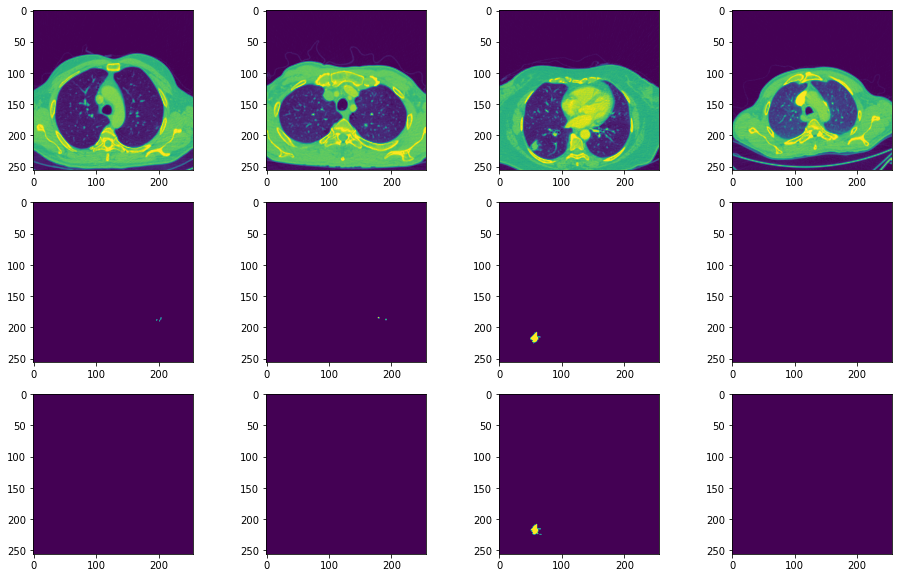

Epoch: 26/30
Got 69368294/69402624 with acc 99.95
Dice score: 0.9009160519991578


100%|██████████| 707/707 [03:42<00:00,  3.17it/s, loss=0.167] 


=> Saving checkpoint
Epoch: 27/30
Got 69368192/69402624 with acc 99.95
Dice score: 0.8993546565356225


100%|██████████| 707/707 [03:43<00:00,  3.17it/s, loss=0.255] 


=> Saving checkpoint
Epoch: 28/30
Got 69369591/69402624 with acc 99.95
Dice score: 0.899864528707582


100%|██████████| 707/707 [03:43<00:00,  3.16it/s, loss=0.377] 


=> Saving checkpoint
Epoch: 29/30
Got 69369131/69402624 with acc 99.95
Dice score: 0.9025628805192722


100%|██████████| 707/707 [03:42<00:00,  3.17it/s, loss=0.0217]


=> Saving checkpoint
Epoch: 30/30
Got 69370064/69402624 with acc 99.95
Dice score: 0.9035804001041263
Finshed Training.
Training duration: 2:02:08.683731
Log saved as: log_bs_12_lr_0.0001_w_0.5.csv
Hyperparameters -> bs: 12 lr: 0.0001 loss: dice_bce weight: 0.5
Finished data loading.


100%|██████████| 707/707 [03:33<00:00,  3.31it/s, loss=0.554]


=> Saving checkpoint


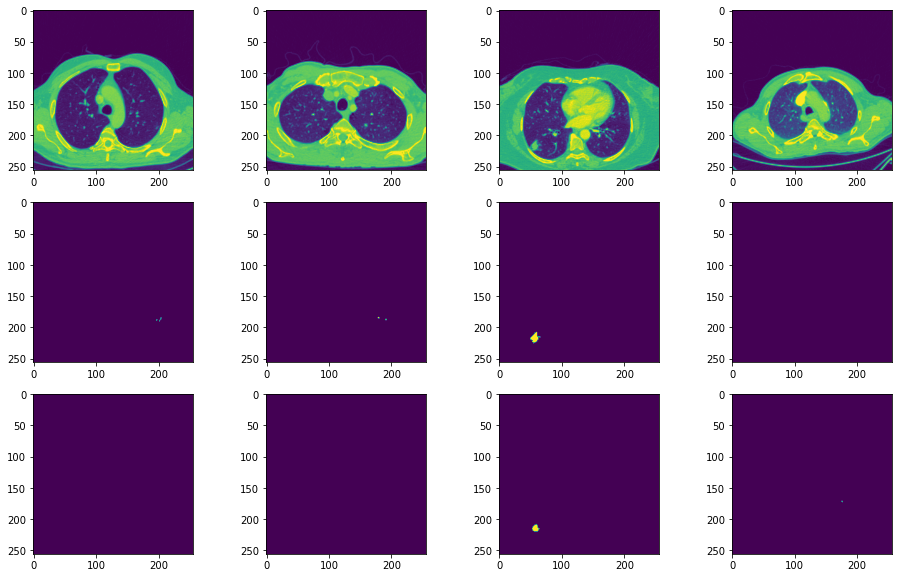

Epoch: 1/30
Got 69224497/69402624 with acc 99.74
Dice score: 0.025658290505369385


100%|██████████| 707/707 [03:33<00:00,  3.31it/s, loss=0.452]


=> Saving checkpoint
Epoch: 2/30
Got 69279848/69402624 with acc 99.82
Dice score: 0.13011032408087495


100%|██████████| 707/707 [03:33<00:00,  3.31it/s, loss=0.512]


=> Saving checkpoint
Epoch: 3/30
Got 69264020/69402624 with acc 99.80
Dice score: 0.4337741964413611


100%|██████████| 707/707 [03:34<00:00,  3.29it/s, loss=0.0859]


=> Saving checkpoint
Epoch: 4/30
Got 69333417/69402624 with acc 99.90
Dice score: 0.7356572520595073


100%|██████████| 707/707 [03:35<00:00,  3.29it/s, loss=0.465] 


=> Saving checkpoint
Epoch: 5/30
Got 69331465/69402624 with acc 99.90
Dice score: 0.762774589795017


100%|██████████| 707/707 [03:35<00:00,  3.27it/s, loss=0.0898]


=> Saving checkpoint


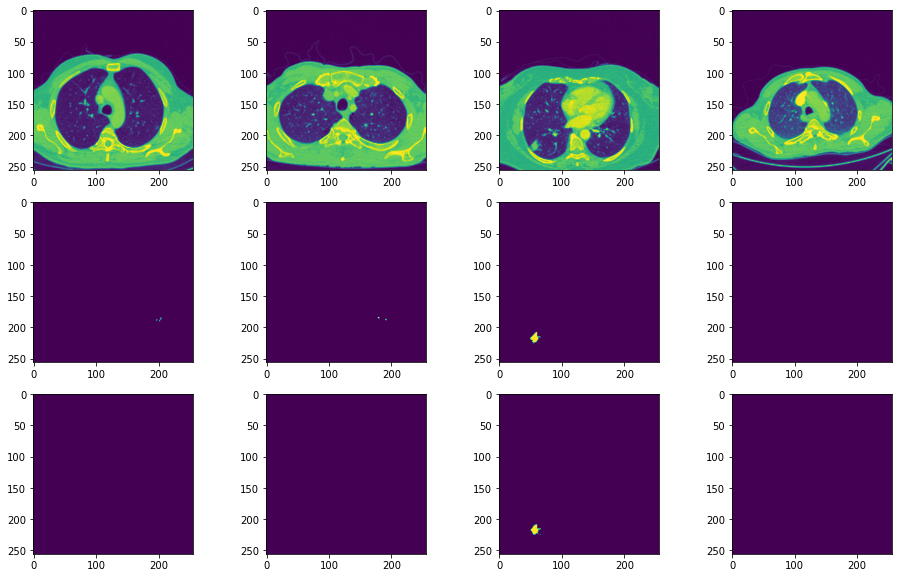

Epoch: 6/30
Got 69338911/69402624 with acc 99.91
Dice score: 0.7934086707619987


100%|██████████| 707/707 [03:35<00:00,  3.28it/s, loss=0.4]   


=> Saving checkpoint
Epoch: 7/30
Got 69343524/69402624 with acc 99.91
Dice score: 0.8099764218811554


100%|██████████| 707/707 [03:37<00:00,  3.26it/s, loss=0.514] 


=> Saving checkpoint
Epoch: 8/30
Got 69344658/69402624 with acc 99.92
Dice score: 0.8183304113079621


100%|██████████| 707/707 [03:37<00:00,  3.25it/s, loss=0.372] 


=> Saving checkpoint
Epoch: 9/30
Got 69345864/69402624 with acc 99.92
Dice score: 0.8269599061980208


100%|██████████| 707/707 [03:38<00:00,  3.24it/s, loss=0.0211]


=> Saving checkpoint
Epoch: 10/30
Got 69352203/69402624 with acc 99.93
Dice score: 0.8388330146278843


100%|██████████| 707/707 [03:39<00:00,  3.22it/s, loss=0.173] 


=> Saving checkpoint


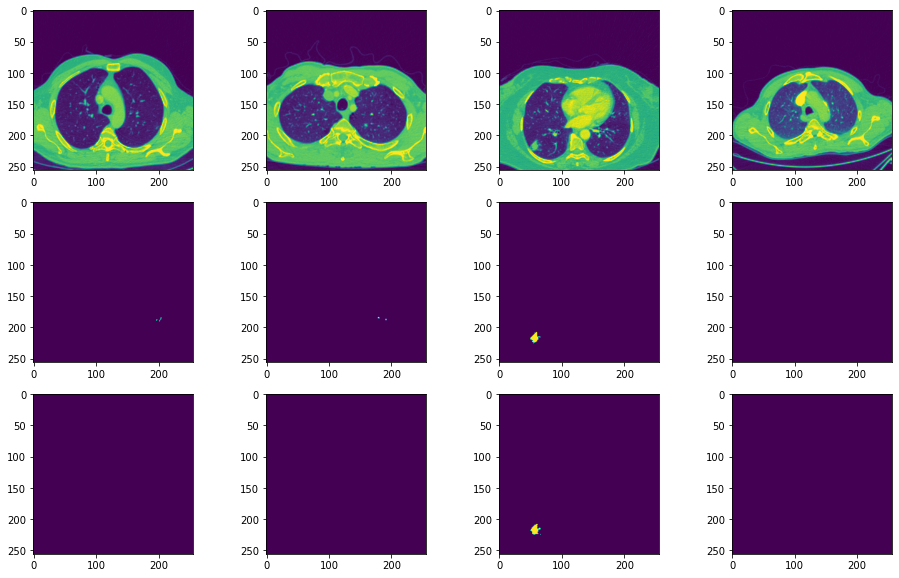

Epoch: 11/30
Got 69349069/69402624 with acc 99.92
Dice score: 0.8389229973984708


100%|██████████| 707/707 [03:39<00:00,  3.22it/s, loss=0.318] 


=> Saving checkpoint
Epoch: 12/30
Got 69349601/69402624 with acc 99.92
Dice score: 0.8373667089265392


100%|██████████| 707/707 [03:40<00:00,  3.21it/s, loss=0.475] 


=> Saving checkpoint
Epoch: 13/30
Got 69352721/69402624 with acc 99.93
Dice score: 0.8503111793119775


100%|██████████| 707/707 [03:40<00:00,  3.20it/s, loss=0.145] 


=> Saving checkpoint
Epoch: 14/30
Got 69355412/69402624 with acc 99.93
Dice score: 0.854168708137754


100%|██████████| 707/707 [03:41<00:00,  3.19it/s, loss=0.0906]


=> Saving checkpoint
Epoch: 15/30
Got 69349482/69402624 with acc 99.92
Dice score: 0.821467105244108


100%|██████████| 707/707 [03:42<00:00,  3.18it/s, loss=0.0558]


=> Saving checkpoint


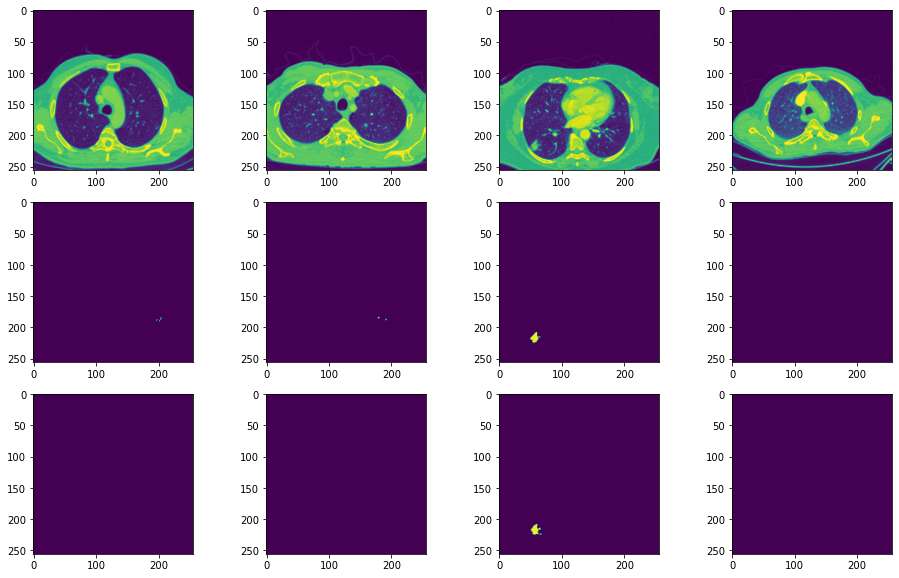

Epoch: 16/30
Got 69357684/69402624 with acc 99.94
Dice score: 0.8642690664628238


100%|██████████| 707/707 [03:42<00:00,  3.18it/s, loss=0.0934]


=> Saving checkpoint
Epoch: 17/30
Got 69356146/69402624 with acc 99.93
Dice score: 0.8565279644023555


100%|██████████| 707/707 [03:42<00:00,  3.18it/s, loss=0.504] 


=> Saving checkpoint
Epoch: 18/30
Got 69354139/69402624 with acc 99.93
Dice score: 0.8579962321471521


100%|██████████| 707/707 [03:42<00:00,  3.17it/s, loss=0.0392]


=> Saving checkpoint
Epoch: 19/30
Got 69357509/69402624 with acc 99.93
Dice score: 0.8649474475274923


100%|██████████| 707/707 [03:43<00:00,  3.16it/s, loss=0.126] 


=> Saving checkpoint
Epoch: 20/30
Got 69356915/69402624 with acc 99.93
Dice score: 0.8594662500313275


100%|██████████| 707/707 [03:42<00:00,  3.17it/s, loss=0.272] 


=> Saving checkpoint


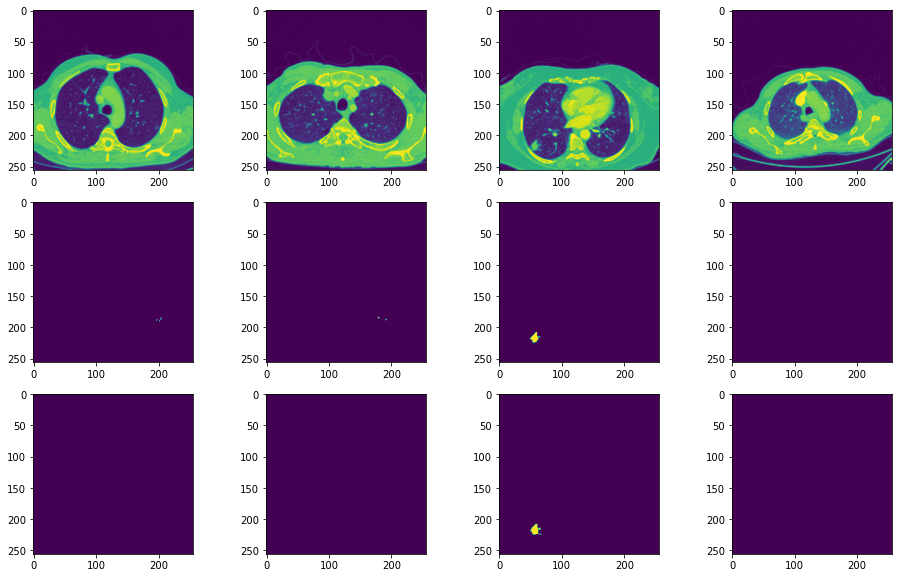

Epoch: 21/30
Got 69358112/69402624 with acc 99.94
Dice score: 0.8600532482783421


100%|██████████| 707/707 [03:43<00:00,  3.16it/s, loss=0.491] 


=> Saving checkpoint
Epoch: 22/30
Got 69354694/69402624 with acc 99.93
Dice score: 0.8473265407802116


100%|██████████| 707/707 [03:43<00:00,  3.16it/s, loss=0.0276]


=> Saving checkpoint
Epoch: 23/30
Got 69359920/69402624 with acc 99.94
Dice score: 0.871239262330549


100%|██████████| 707/707 [03:43<00:00,  3.16it/s, loss=0.397] 


=> Saving checkpoint
Epoch: 24/30
Got 69351597/69402624 with acc 99.93
Dice score: 0.8460400761744302


100%|██████████| 707/707 [03:44<00:00,  3.16it/s, loss=0.0922]


=> Saving checkpoint
Epoch: 25/30
Got 69362043/69402624 with acc 99.94
Dice score: 0.8782091698003306


100%|██████████| 707/707 [03:43<00:00,  3.16it/s, loss=0.0397]


=> Saving checkpoint


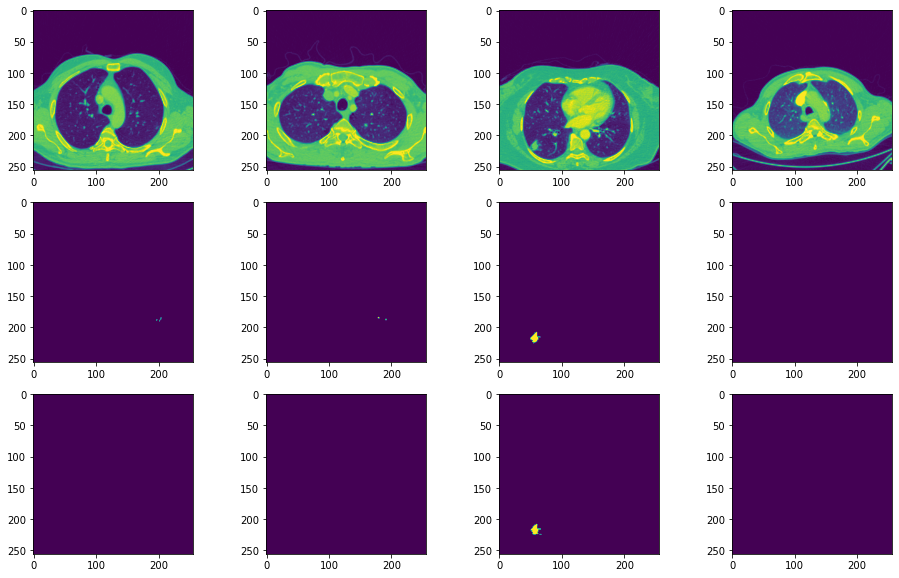

Epoch: 26/30
Got 69362733/69402624 with acc 99.94
Dice score: 0.8790285266042117


100%|██████████| 707/707 [03:42<00:00,  3.18it/s, loss=0.482] 


=> Saving checkpoint
Epoch: 27/30
Got 69359886/69402624 with acc 99.94
Dice score: 0.8758531192432938


100%|██████████| 707/707 [03:43<00:00,  3.16it/s, loss=0.0162]


=> Saving checkpoint
Epoch: 28/30
Got 69365865/69402624 with acc 99.95
Dice score: 0.8869861246018796


100%|██████████| 707/707 [03:43<00:00,  3.17it/s, loss=0.0223]


=> Saving checkpoint
Epoch: 29/30
Got 69365353/69402624 with acc 99.95
Dice score: 0.8886538311962657


100%|██████████| 707/707 [03:43<00:00,  3.17it/s, loss=0.0403]


=> Saving checkpoint
Epoch: 30/30
Got 69367673/69402624 with acc 99.95
Dice score: 0.8950974584892212
Finshed Training.
Training duration: 2:01:58.669989
Log saved as: log_bs_12_lr_0.0001_w_0.5.csv
Hyperparameters -> bs: 12 lr: 0.0001 loss: dice_bce weight: 0.5


In [7]:
#train.py
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    accumulated_loss = 0
    dsc = 0
    iou = 0 
    for batch_idx, (data, targets) in enumerate(loop):
#         try:
#             assert np.array_equal(np.unique(targets.cpu().numpy()), np.array([0.,1.]))
#         except AssertionError:
#             fig, ax = plt.subplots(1,4, figsize=(16,10))
#             for i in range(4):
#                 ax[i].imshow(targets.cpu().numpy()[i].squeeze())
#             plt.show()
#             plt.close()
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            data = data.float() # linha alterada do algoritmo original
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            accumulated_loss += loss.item()
            dsc += dice_coef(predictions, targets).item()
            iou += iou_score(predictions, targets)
            
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())
    return {'loss': accumulated_loss/len(loader),
            'dice': dsc/len(loader),
            'iou': iou/len(loader)}

def train_unet(augment, rot_prob, hflip_prob):
    start = time.time()
    if augment:
        train_transform = A.Compose(
            [
                A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
                A.Rotate(limit=15, p=rot_prob, border_mode=cv2.BORDER_CONSTANT),
                A.HorizontalFlip(p=hflip_prob),
#                 A.VerticalFlip(p=0.1),
                A.Normalize(
                    mean=[0.0],
                    std=[1.0],
                    max_pixel_value=1.0,
                ),
                ToTensorV2(),
            ],
        )
    else:
        train_transform = A.Compose(
            [
                A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
                A.Normalize(
                    mean=[0.0],
                    std=[1.0],
                    max_pixel_value=1.0,
                ),
                ToTensorV2(),
            ],
        )        

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=1.0,
            ),
            ToTensorV2(),
        ],
    )

    model = UNET(in_channels=IN_CHANNELS, out_channels=1).to(DEVICE)
    weight=WEIGHT
    loss_fn = DiceBCELoss(weight=weight)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )
    print("Finished data loading.")

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)
    if str(loss_fn) == 'DiceLoss()':
        loss_name = 'dice'
    elif str(loss_fn) == 'DiceBCELoss()':
        loss_name = 'dice_bce'
    #validate(val_loader, model, loss_fn, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()
    log = pd.DataFrame(index=[],columns= ['epoch','train_loss','val_loss','train_dice','val_dice'])
#     comment = f"runs/bs: {BATCH_SIZE} lr: {LEARNING_RATE} loss: {loss_name} weight: {weight} aug: {str(augment)}"
    comment = f"runs/bs: {BATCH_SIZE} lr: {LEARNING_RATE} loss: {loss_name} weight: {weight} aug: rot_15_{rot_prob}_bmc h_flip_{hflip_prob}"
    writer = SummaryWriter(comment=comment)

    trigger = 0
    best_dice = 0
    
    for epoch in range(NUM_EPOCHS):
        train_log = train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # check accuracy
        val_log = validate(val_loader, model, loss_fn, epoch, device=DEVICE)

        # logging
        tmp = pd.Series([
            int(epoch),
            train_log['loss'],
            val_log['loss'],
            train_log['dice'],
            val_log['dice'],
            train_log['iou'],
            val_log['iou']
        ], index=['epoch', 'train_loss', 'val_loss','train_dice','val_dice','train_iou','val_iou'])
        log = log.append(tmp, ignore_index=True)
        
        step = int(epoch)
#         writer.add_histogram("final_conv", model.final_conv.weight, step)
#         writer.add_histogram("donw0_first_conv", model.downs[0].conv[0].weight, step)
#         writer.add_histogram("up0_first_conv", model.downs[0].conv[0].weight, step)
        writer.add_scalar("train loss", train_log['loss'], step)
        writer.add_scalar("val loss", val_log['loss'], step)
        writer.add_scalar("traindice", train_log['dice'], step)
        writer.add_scalar("val dice", val_log['dice'], step)
        writer.add_scalar("train iou", train_log['iou'], step)
        writer.add_scalar("val iou", val_log['iou'], step)
        
        trigger += 1
        
        #early stopping
        if val_log['dice'] > best_dice:
            torch.save(
                model.state_dict(), 
                f'model_outputs/mix_bs_{BATCH_SIZE}_lr_{LEARNING_RATE}_loss_{loss_name}_weight_{weight}_aug_{str(augment)}.pth'
            )
            best_dice = val_log['dice']
            trigger = 0
                
        if trigger >= PATIENCE:
            print("=> early stopping")
            # print some examples to a folder
            save_predictions_as_imgs(
                val_loader, model, folder="saved_images/", device=DEVICE
            )
            break
            
    writer.close()
    end = time.time()
    duration = end - start
    print("Finshed Training.")
    print(f"Training duration: {datetime.timedelta(seconds=duration)}")
    log_name = f'log_bs_{BATCH_SIZE}_lr_{LEARNING_RATE}_w_{weight}.csv'
    log.to_csv(f"logs/{log_name}", index=False)
    print(f"Log saved as: {log_name}")
    print(f"Hyperparameters -> bs: {BATCH_SIZE} lr: {LEARNING_RATE} loss: {loss_name} weight: {weight}")


# Hyperparameters etc.
LEARNING_RATE = 5e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 12
NUM_EPOCHS = 30
NUM_WORKERS = 2
IMAGE_HEIGHT = 256  
IMAGE_WIDTH = 256  
IN_CHANNELS = 1 # Number of color channels
PIN_MEMORY = True
LOAD_MODEL = False
PATIENCE = 5
WEIGHT = 0.5
SPLITTED_DATA_FOLDER = "sampled_splitted_data"
TRAIN_IMG_DIR = f"{SPLITTED_DATA_FOLDER}/train/images/"
TRAIN_MASK_DIR = f"{SPLITTED_DATA_FOLDER}/train/masks/"
VAL_IMG_DIR = f"{SPLITTED_DATA_FOLDER}/val/images/"
VAL_MASK_DIR = f"{SPLITTED_DATA_FOLDER}/val/masks/"    

# Hyperparameter Search
for LEARNING_RATE in [1e-4]:
    for hflip_prob in [0.2,0,0.1]:
        train_unet(True, 0, hflip_prob)

In [53]:
# Model Overfit for Sanity Check

x,target = next(iter(train_loader))

model = UNET(1, 1)
# 'x = torch.randn(1, 1, 224, 224)
# target = torch.randint(0, 2, (1, 1, 224, 224)).float()'

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = DiceBCELoss()
target = target.float().unsqueeze(1)

for epoch in range(50):
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    print('Epoch {}, loss {}, accuracy {}, dice {}'.format(
        epoch,
        loss.item(),
        (target[0, 0] == (output[0, 0] > 0.0)).float().mean().item(),
        dice_coef(output, target)))

Epoch 0, loss 1.4901803731918335, accuracy 0.0305328369140625, dice 0.004696843979719707
Epoch 1, loss 1.4702866077423096, accuracy 0.0329132080078125, dice 0.005000020517534269
Epoch 2, loss 1.4529731273651123, accuracy 0.049163818359375, dice 0.005113313683049694


KeyboardInterrupt: 